# Using Tensorflow DALI plugin with sparse tensors

### Overview

Using our DALI data loading and augmentation pipeline with Tensorflow is pretty simple.

However, sometimes a batch of data that uses wants to extract from the pipeline cannot be represented as a dense tensor. In such case, DALI op utilizes TensorFlow SparseTensor.
Please keep in mind that SparseTensors are supported only for the CPU based piepline.

### Defining the data loading pipeline

First, we start by defining some simple pipeline that will return data as a sparse tensor. To ochieve this, we will use well known COCO data set. Each image may have 0 or more bounding boxes with labels describing objects present in it.Wa want to return images in a normalized way, while labels and bounding boxes will be represented as sparse tensors.
At the begginig let us define some global parameters

In [1]:
from __future__ import print_function
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

BATCH_SIZE = 32
DEVICES = 1
subset = "val"
file_root = "/data/coco/coco-2017/coco2017/" + subset + "2017"
annotations_file = "/data/coco/coco-2017/coco2017/annotations/instances_val2017.json"

Pipeline with the COCO reader is created. Please notice that while images are processed, other data from COCO ara passes through.

In [2]:
class COCOPipeline(Pipeline):                                                                    
    def __init__(self, batch_size, num_threads, device_id, num_gpus):                                       
        super(COCOPipeline, self).__init__(batch_size, num_threads, device_id, seed = 15)        
        self.input = ops.COCOReader(file_root = file_root, annotations_file = annotations_file,
                                     shard_id = device_id, num_shards = num_gpus, ratio=False, save_img_ids=True)    
        self.decode = ops.HostDecoder(device = "cpu", output_type = types.RGB)
        self.resize = ops.Resize(device = "cpu",
                                 image_type = types.RGB,
                                 interp_type = types.INTERP_LINEAR)
        self.cmn = ops.CropMirrorNormalize(device = "cpu",
                                            output_dtype = types.FLOAT,
                                            crop = (224, 224),
                                            image_type = types.RGB,
                                            mean = [128., 128., 128.],
                                            std = [1., 1., 1.])
        self.res_uniform = ops.Uniform(range = (256.,480.))
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.cast = ops.Cast(device = "cpu",
                             dtype = types.INT32)
                                                                                                
    def define_graph(self):                                                                       
        inputs, bboxes, labels, im_ids = self.input()
        images = self.decode(inputs)
        images = self.resize(images, resize_shorter = self.res_uniform())
        output = self.cmn(images, crop_pos_x = self.uniform(),
                          crop_pos_y = self.uniform())
        output = self.cast(output)
        return (output, bboxes, labels, im_ids) 

Next, we instatiate the pipelines with the right parameters. We will create one pipeline per GPU, by specifying the right `device_id` for each pipeline.

The difference is that instead of calling `pipeline.build` and using it, we will pass the pipeline object to the TensorFlow operator.

In [3]:
pipes = [COCOPipeline(batch_size=BATCH_SIZE, num_threads=2, device_id = device_id, num_gpus = DEVICES) for device_id in range(DEVICES)]

### Using DALI TensorFlow plugin

Let's start by importing Tensorflow and the DALI Tensorflow plugin as `dali_tf`.

In [4]:
import tensorflow as tf
import nvidia.dali.plugin.tf as dali_tf
import time

We can now use `nvidia.dali.plugin.tf.DALIIterator()` method to get the Tensorflow Op that will produce the tensors we will
use in the Tensorflow graph.

For each DALI pipeline, we use `daliop` that returns a Tensorflow tensor tuple that we will store in `image, bouding boxes, labels and image ids`.To enable sparse tensor generation `sparse` argument need to be filled with `True` values for the output elements that are going to be represented as a sparse tensors.

In [5]:
daliop = dali_tf.DALIIterator()

images = []
bboxes = []
labels = []
image_ids = []
for d in range(DEVICES):
    with tf.device('/cpu'):
        image, bbox, label, id = daliop(pipeline = pipes[d],
            shapes = [(BATCH_SIZE, 3, 224, 224), (), (), ()],
            dtypes = [tf.int32, tf.float32, tf.int32, tf.int32], sparse = [False, True, True])

        images.append(image)
        bboxes.append(bbox)
        labels.append(label)
        image_ids.append(id)

### Using the tensors in a simple Tensorflow graph

We will use `images`, `bboxes`, `labels` and `image_ids` tensors list in our Tensorflow graph definition.
Then run a very simple _one op graph_ session that will output the batch of data. Then we will print bounding boxes, labels and image_ids.

In [6]:
with tf.Session() as sess:
    all_img_per_sec = []
    total_batch_size = BATCH_SIZE * DEVICES
    
    start_time = time.time()

    # The actual run with our dali_tf tensors
    res_cpu = sess.run([images, bboxes, labels, image_ids])
print(res_cpu[1])
print(res_cpu[2])
print(res_cpu[3])

[SparseTensorValue(indices=array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  2],
       ...,
       [30,  2,  3],
       [31,  0,  0],
       [31,  0,  1]]), values=array([217.62, 240.54,  38.99, ..., 173.36, 105.4 , 113.74], dtype=float32), dense_shape=array([32, 26,  4]))]
[SparseTensorValue(indices=array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 0, 13],
       [ 0, 14],
       [ 0, 15],
       [ 0, 16],
       [ 0, 17],
       [ 0, 18],
       [ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1,  5],
       [ 1,  6],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 1, 13],
       [ 2,  0],
       [ 2,  1],
       [ 2,  2],
       [ 2,  3],
       [ 2,  4],
       [ 2,  5],
       [ 2,  6],
       [

Let us check the output images with their augmentations! Tensorflow outputs numpy arrays, so we can visualize them easily with `matplotlib`.

We define a `show_images` helper function that will display a sample of our batch.

The batch layout is NCHW so we use transpose to get HWC images, that `matplotlib` can show.

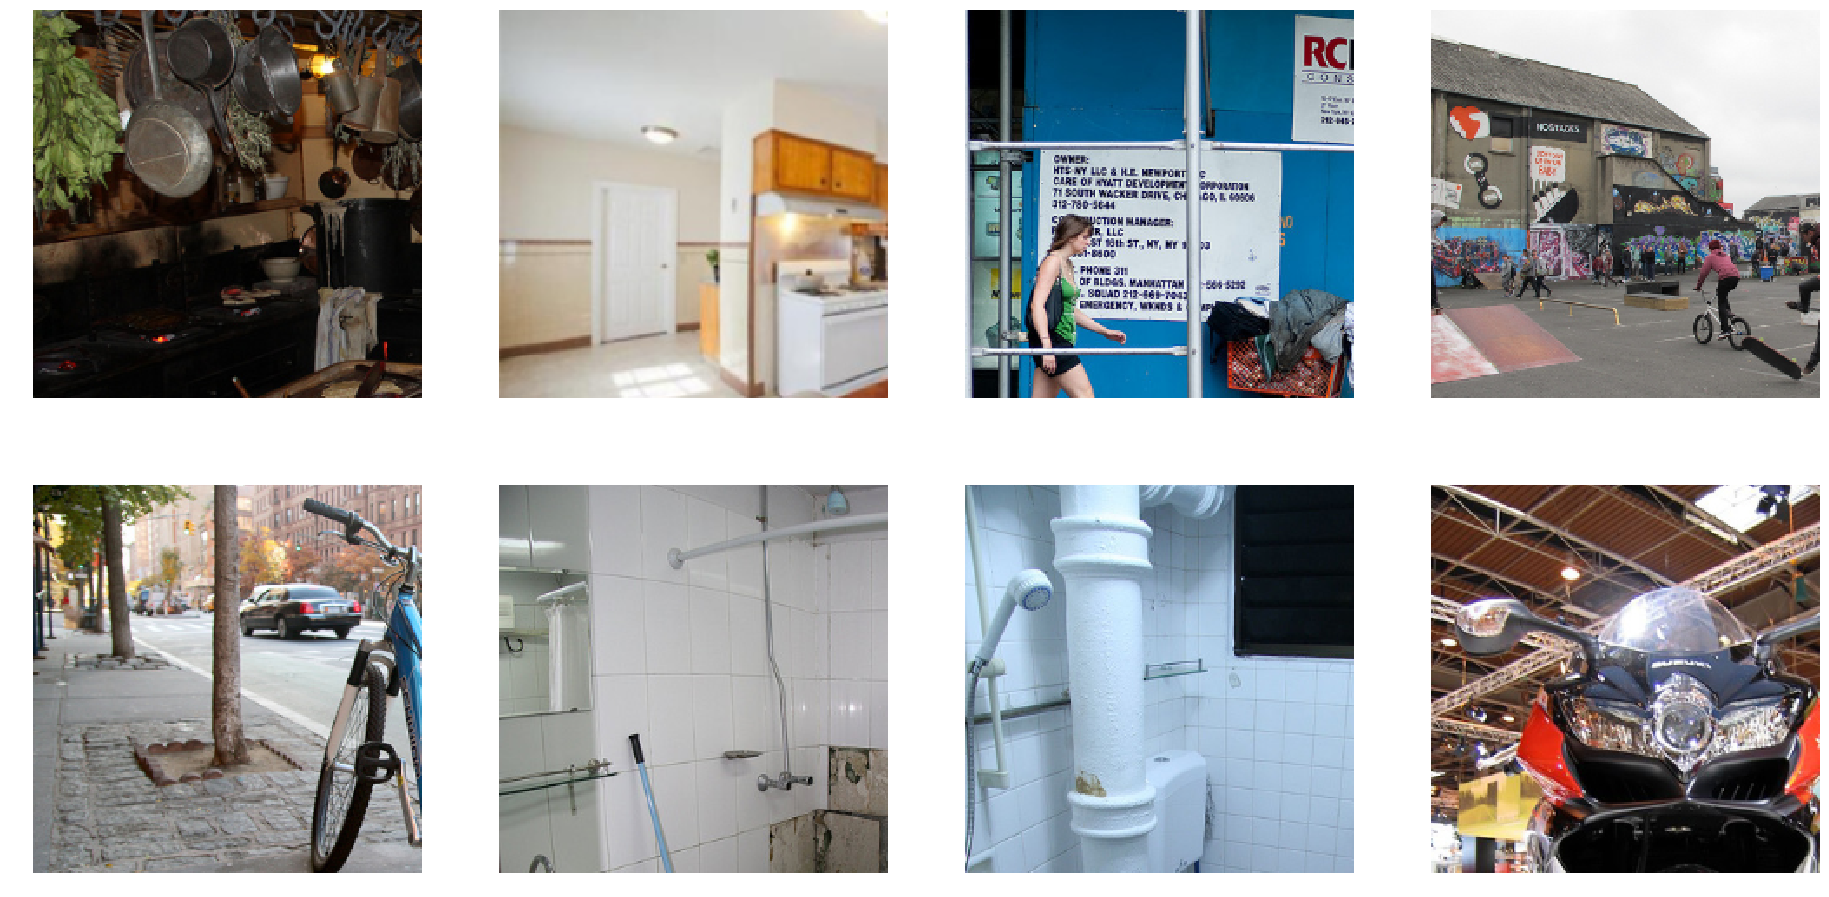

In [7]:
from __future__ import division
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch, nb_images):
    columns = 4
    rows = (nb_images + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(nb_images):
        plt.subplot(gs[j])
        plt.axis("off")
        img = image_batch[0][j].transpose((1,2,0)) + 128
        plt.imshow(img.astype('uint8'))
show_images(res_cpu[0], 8)